In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#### Helper Functions

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range)
  plt.ylim([0, ymax])

In [4]:
steinmetz_spikes = np.load('../data/spike_times.npz', allow_pickle=True)['spike_times']

#### Optimization and Information

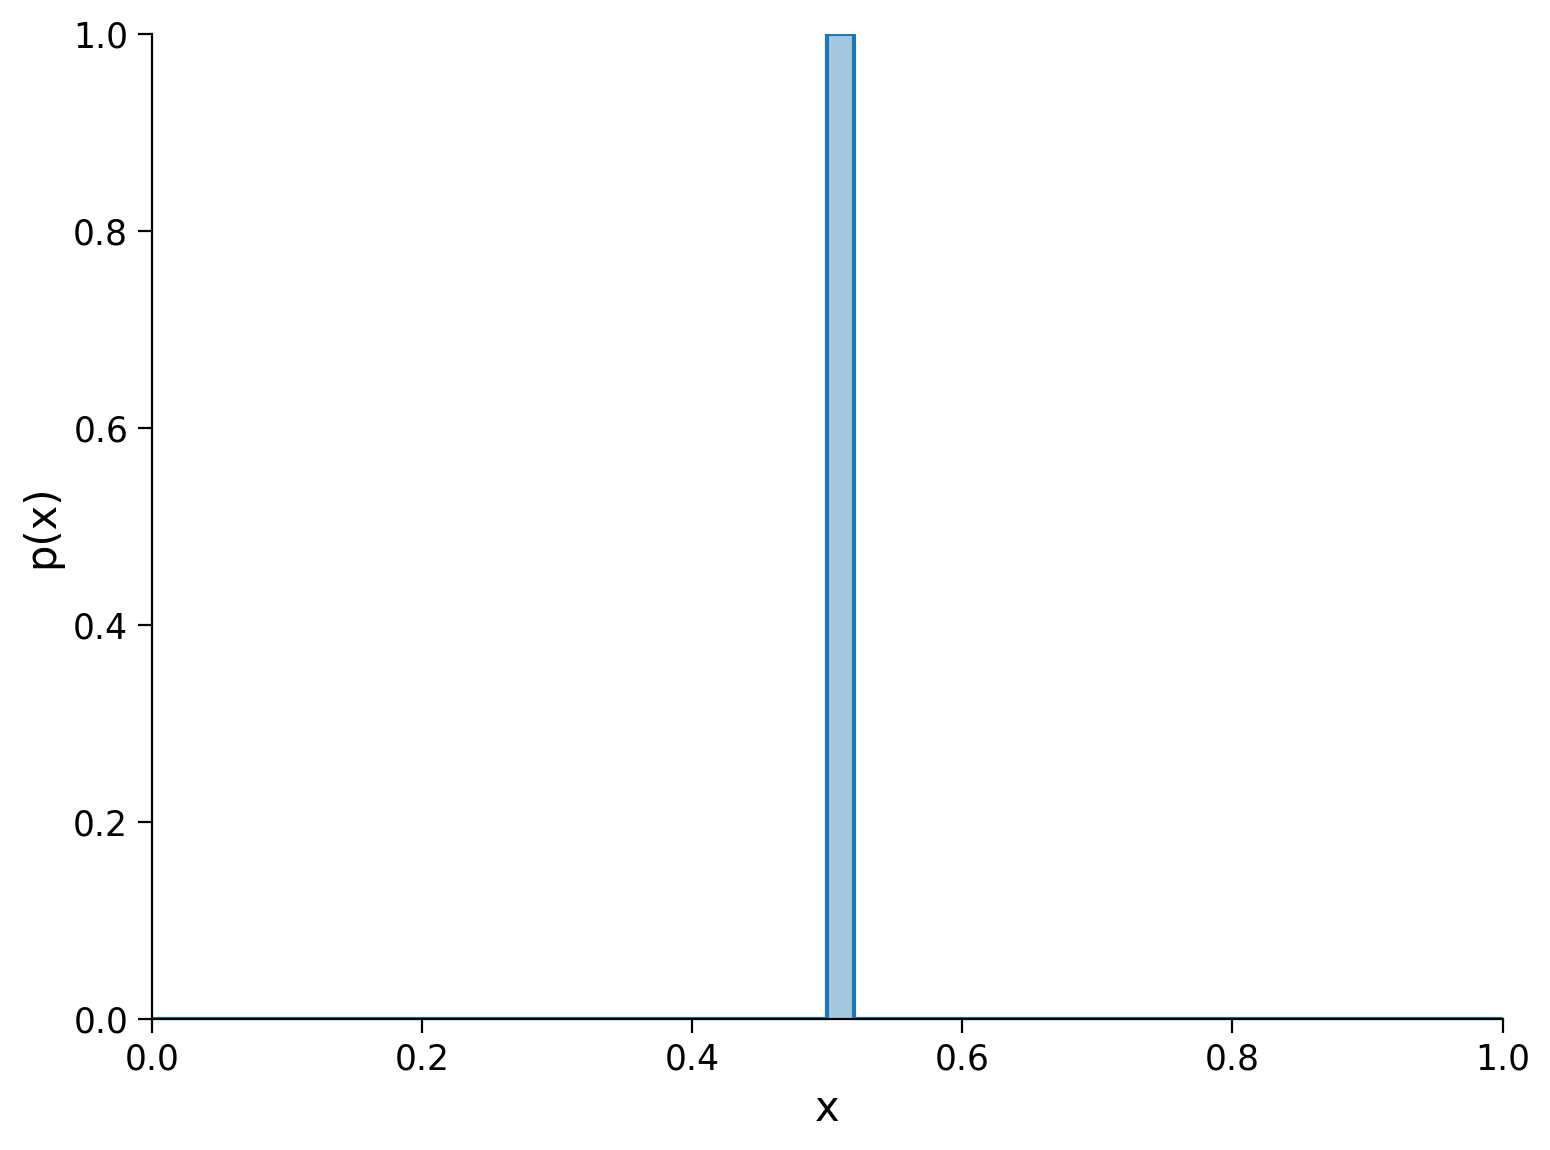

In [5]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1)
plt.show()

In [6]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -1 * np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


#### Information from Spikes

In [7]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

In [8]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


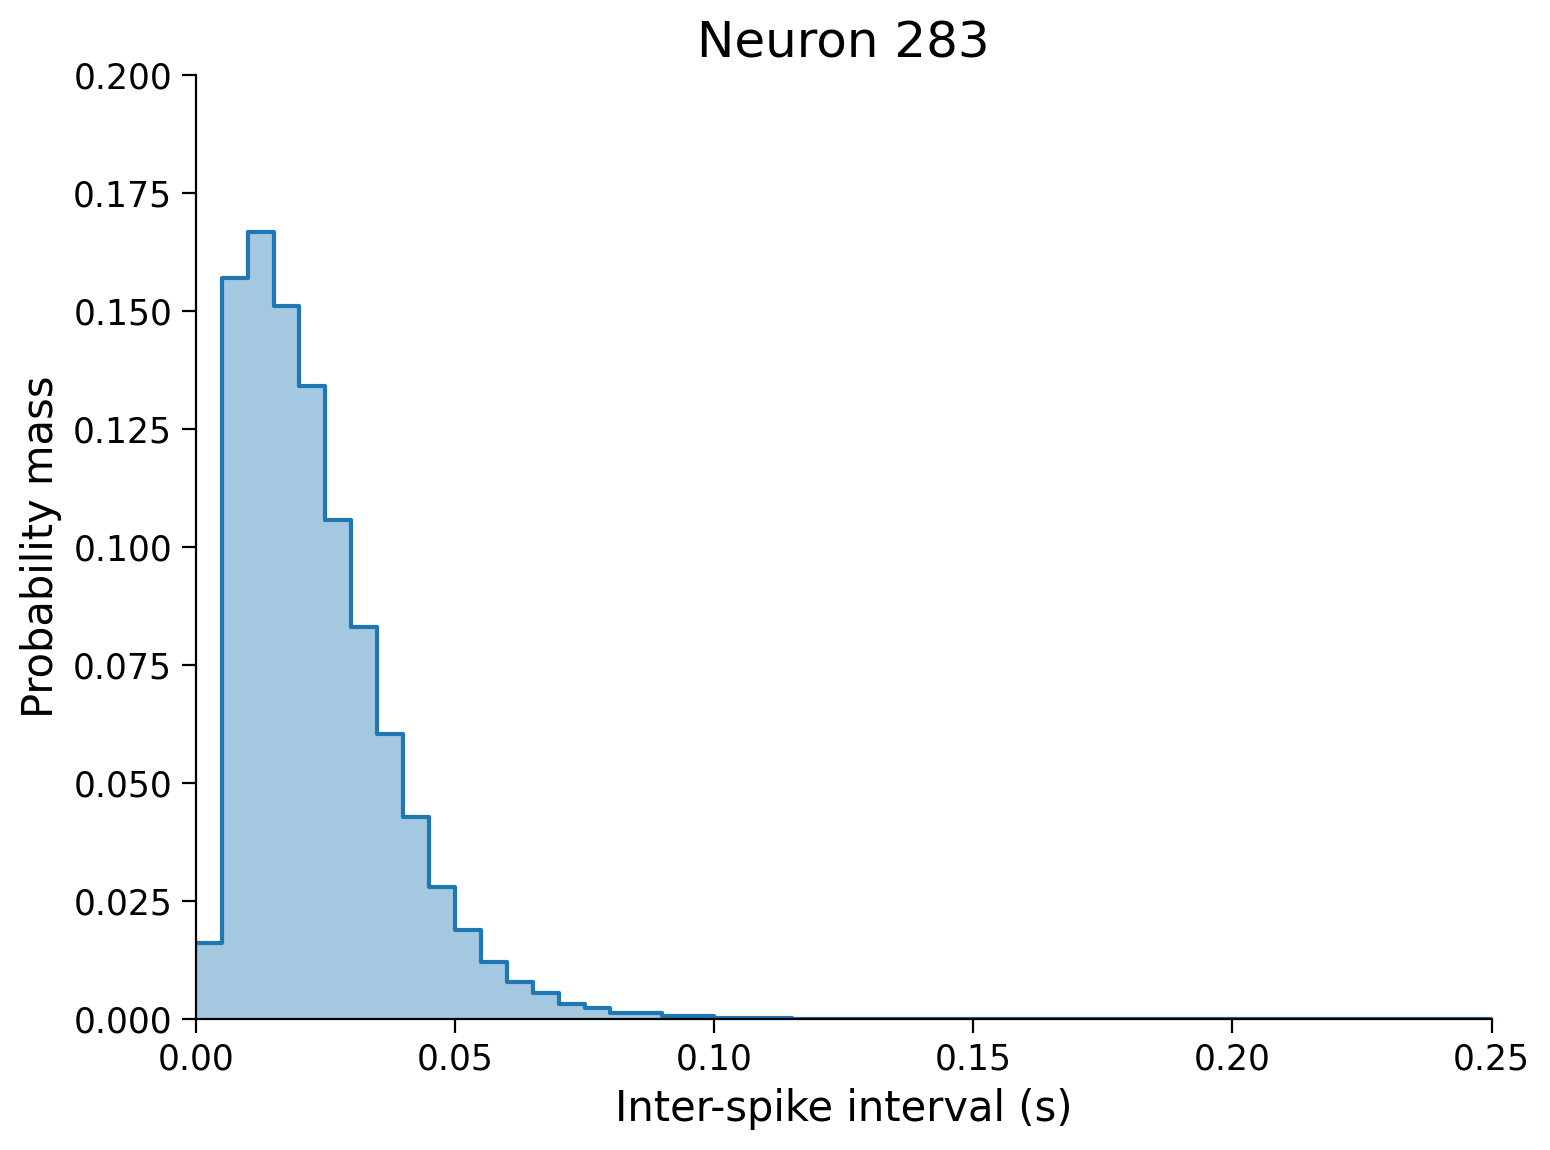

In [9]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""

  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

In [10]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


In [ ]:
@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = pmf_from_counts(counts)

  plot_pmf(pmf, isi_range)
  plt.title(f"Neuron {neuron}: H = {entropy(pmf):.2f} bits")
  plt.show()

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…